In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

###### loading data

In [2]:
from rdkit.Chem import PandasTools

sol_test = PandasTools.LoadSDF('/home/sphalo/data_science/data/solubility.test.sdf')
sol_train = PandasTools.LoadSDF('/home/sphalo/data_science/data/solubility.train.sdf')

###### Extracting Features and Output

In [3]:
from rdkit.Chem import AllChem

In [4]:
def generate_fps(mol_list):
    """
    Generate rdkit molecule
    :param smiles: mol-list,
    Generate Morgan fingerprints as 2048 bits
    :param mol: input molecule
    Generate fingerprints
    :param fingerprints: input fingerprints
    """
    fps = []
    for mol in tqdm(mol_list):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
        fps.append(fp)
    return fps

In [5]:
train_x = np.array(generate_fps(sol_train['ROMol']))
train_y = np.array(sol_train['SOL_classification'].values)

  0%|          | 0/1025 [00:00<?, ?it/s]

In [6]:
test_x = np.array(generate_fps(sol_test['ROMol']))
test_y = np.array(sol_test['SOL_classification'].values)

  0%|          | 0/257 [00:00<?, ?it/s]

###### class labelling

In [7]:
# Lets encode target labels (y)
from sklearn.preprocessing import LabelEncoder

# creating LabelEncoder
label_encoder = LabelEncoder()

In [8]:
# encode y variable to numerical variables
label_encoder.fit(train_y)
train_y = label_encoder.transform(train_y)

In [9]:
# encode y variable to numerical variables
label_encoder.fit(test_y)
test_y = label_encoder.transform(test_y)

###### Data Distribution

In [10]:
print('Data Distribution of Training Distribution')
sol_train['SOL_classification'].value_counts()

Data Distribution of Training Distribution


(A) low       417
(B) medium    402
(C) high      206
Name: SOL_classification, dtype: int64

In [11]:
print('Data Distribution of Test Distribution')
sol_test['SOL_classification'].value_counts()

Data Distribution of Test Distribution


(B) medium    115
(A) low       102
(C) high       40
Name: SOL_classification, dtype: int64

###### Model training

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [13]:
accu_scores = []
model = KNeighborsClassifier()
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(train_x, train_y):
    X_train, X_test, y_train, y_test = train_x[train_index], train_x[test_index], \
                                        train_y[train_index], train_y[test_index]
    model.fit(train_x, train_y)
    y_pred = model.predict(X_test)
    accu_scores.append(accuracy_score(y_test, y_pred))

###### model evaluation

In [14]:
print('Model accuracy: ', np.mean(accu_scores))

Model accuracy:  0.7286502950694842


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, \
                            recall_score, roc_auc_score, f1_score, ConfusionMatrixDisplay

In [16]:
classes = label_encoder.classes_
classes

array(['(A) low', '(B) medium', '(C) high'], dtype=object)

In [18]:
print(f"Accuracy Score= {accuracy_score(y_test, y_pred):.3f}")

print(f"Precision Score  = {precision_score(y_test,y_pred,average='micro'):.3f}")

print(f"Recall Score  = {recall_score(y_test,y_pred,average='micro'):.3f}")

print(f"F1 Score = {f1_score(y_test, y_pred,average='micro'):.3f}")

pred_prob = model.predict_proba(X_test)
print(f"ROC AUC Score = {roc_auc_score(y_test, pred_prob, multi_class='ovr'):.3f}")
print()

# report = classification_report(y_test,y_pred, target_names=classes)
# print('classification report\n')
# print(report)

# print('Confusion Matrix\n')
# print(pd.crosstab(y_test, y_pred, rownames=['Actual Classes'], colnames=['Predicted Classes']))

Accuracy Score= 0.745
Precision Score  = 0.745
Recall Score  = 0.745
F1 Score = 0.745
ROC AUC Score = 0.907



###### Hyperparameter Tuning (Randomized GridSearchCV)

In [26]:
from sklearn.model_selection import RandomizedSearchCV

In [51]:
# list hyperpameters we want to tune
n_neighbors = np.arange(2,11,1)
leaf_size = np.arange(2,11,1)
p = np.arange(1,3,1)

# create a dictionary(key value pair) of hperparameter candidates
param_grid = {
    "n_neighbors": n_neighbors,
    "leaf_size": leaf_size,
     "weights": ['uniform', 'distance'],
    "p": p,
}

print(param_grid)

{'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'leaf_size': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'weights': ['uniform', 'distance'], 'p': array([1, 2])}


In [52]:
# create knn classifier
model = KNeighborsClassifier()

# create a gridsearch
gridsearch = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    cv=10,
    random_state=1,
    n_iter=10,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1,
)

# fit the grid search
best_model = gridsearch.fit(train_x,train_y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [53]:
print(f"Model Best Score: {(best_model.best_score_):.3f}")
print(f"Model Best Paramerters: {best_model.best_params_}")

Model Best Score: 0.489
Model Best Paramerters: {'weights': 'distance', 'p': 2, 'n_neighbors': 2, 'leaf_size': 5}


###### Model Evaluation

In [54]:
print(f"Train Accuracy Score: {accuracy_score(train_y, best_model.predict(train_x)):.3f}")
print(f"Test Accuracy Score: {accuracy_score(test_y, best_model.predict(test_x)):.3f}")

Train Accuracy Score: 0.998
Test Accuracy Score: 0.603


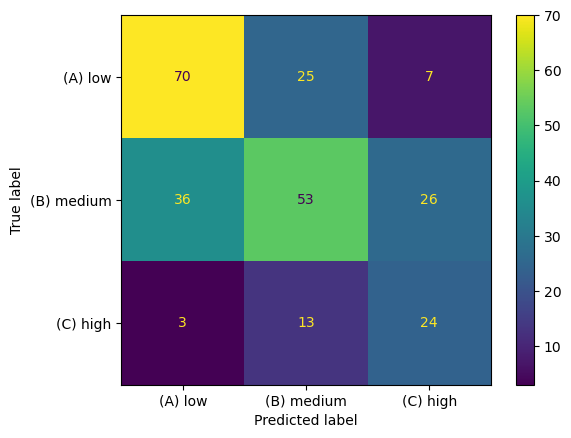

In [148]:
# confusion matrix
cm = confusion_matrix(test_y, best_model.predict(test_x))
cmd = ConfusionMatrixDisplay(cm, display_labels=classes).plot()

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

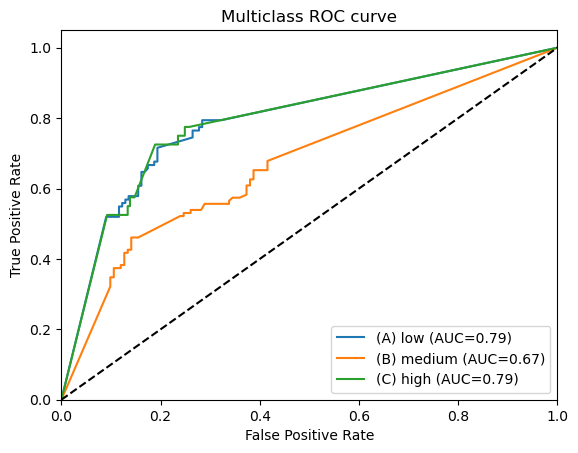

In [55]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# binarize the y_values, which changes shape from (644,) to (644,3)
y_test_binarized = label_binarize(test_y,classes=np.unique(test_y))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):
    #  Compute fpr, tpr, thresholds and roc auc
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], best_model.predict_proba(test_x)[:,i]) 
    # compute AUC score
    roc_auc[i] = auc(fpr[i], tpr[i])
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='-', 
             label='%s (AUC=%0.2f)'%(classes[i],roc_auc[i])) # use (VS Rest) when using one-vs-rest model

plt.rcParams["figure.figsize"] = [6, 5]
plt.rcParams["patch.facecolor"] = 'white'
plt.rcdefaults()

plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()